<a href="https://colab.research.google.com/github/yyyyyokoko/590FaceMaskDetection/blob/master/590_MobileNetV2_for_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, random
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import cv2

from tensorflow.keras.models import load_model



In [ ]:
!ls "/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/Validation"

mask  nomask


In [ ]:
data_train = '/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/Validation/'
data_train

'/content/drive/My Drive/ColabNotebooks/Face Mask Dataset/Validation/'

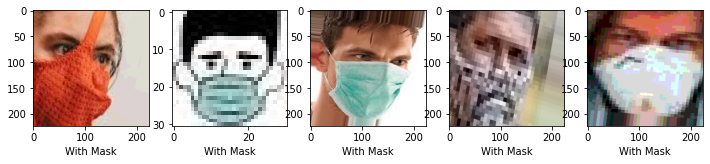

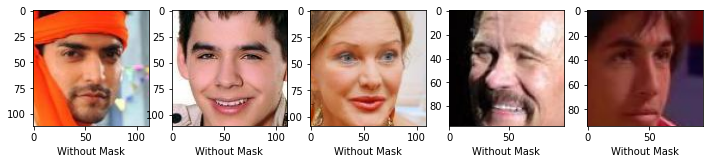

In [ ]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"mask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"mask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"nomask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"nomask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2)

train = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1./255)
valid = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset="validation")

Found 526 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
valid.class_indices

{'mask': 1, 'nomask': 0}

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(160, 160, 3)))

for layer in baseModel.layers:
    layer.trainable = False

model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")


In [ ]:
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
# history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,
#                               validation_data=valid,
#                              validation_steps = len(valid)//32,
#                               callbacks=[checkpoint,earlystop],
#                               epochs=15)


history = model.fit_generator(train,
                              epochs=10,
                              validation_data=valid,
                              callbacks=[checkpoint])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.8365
Epoch 00001: val_accuracy improved from -inf to 0.96154, saving model to moblenet_facemask.h5
17/17 [==============================] - 163s 10s/step - loss: 0.6455 - accuracy: 0.8365 - val_loss: 0.3940 - val_accuracy: 0.9615
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.9392
Epoch 00002: val_accuracy improved from 0.96154 to 0.98462, saving model to moblenet_facemask.h5
17/17 [==============================] - 5s 301ms/step - loss: 0.4557 - accuracy: 0.9392 - val_loss: 0.4498 - val_accuracy: 0.9846
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.9772
Epoch 00003: val_accuracy did not improve from 0.98462
17/17 [==============================] - 5s 287ms/step - loss: 0.4019 - accuracy: 0.9772 - val_loss: 0.4059 - val_accuracy: 0.9846
Epo

In [ ]:
model.evaluate_generator(valid)


Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.3525657653808594, 0.9923076629638672]

In [ ]:
model.save("/content/drive/My Drive/ColabNotebooks/face_mask_new.h5")


In [ ]:
model = load_model('/content/drive/My Drive/ColabNotebooks/face_mask_new.h5')

pred = model.predict_classes(valid)
pred[:15]


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])